In [ ]:
import torch

import os
from tqdm import tqdm
import numpy as np
import pandas as pd

from tqdm import tqdm
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

COLOR_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(COLOR_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

--2020-10-29 00:21:39--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2020-10-29 00:21:39 ERROR 404: Not Found.



In [ ]:
!gdown --id 1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV

Downloading...
From: https://drive.google.com/uc?id=1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV
To: /content/time_series_19-covid-Confirmed.csv
100% 19.2k/19.2k [00:00<00:00, 14.7MB/s]


In [ ]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')
len(list(df["Country/Region"].unique()))

75

In [ ]:
df = df.iloc[:, 4:]
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,1,9,15,39,60,70,106,152,200,237,297,340,408,480,530,591,665,733,779,830,860,889,910,934,950,962,973,982,986,987,988,989,989,989,989,989,989,990,990,990,990
1,14,22,36,41,68,80,91,111,114,139,168,191,212,228,253,274,297,315,326,337,342,352,366,372,375,380,381,387,393,395,396,399,399,399,400,400,410,410,411,413,414
2,6,9,27,57,75,110,132,147,182,211,247,300,337,366,389,411,426,428,468,486,505,518,529,537,544,551,553,555,560,567,572,573,575,576,576,576,576,576,576,576,576
3,1,5,10,18,35,59,80,84,101,120,144,159,179,194,205,215,224,239,250,261,267,272,279,281,285,287,290,292,293,293,293,293,293,293,294,294,296,296,296,296,296
4,0,2,2,4,7,14,19,24,26,29,40,51,55,57,62,62,67,79,83,83,86,87,90,90,90,90,91,91,91,91,91,91,91,91,91,91,91,91,91,91,91


In [ ]:
daily_cases = df.sum(axis = 0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head(5)

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

In [ ]:
daily_cases_diff = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
mean_daily_cases = np.mean(daily_cases_diff)

print("The average number of new cases is {:.2f} per day.".format(mean_daily_cases))

The average number of new cases is 2202.76 per day.


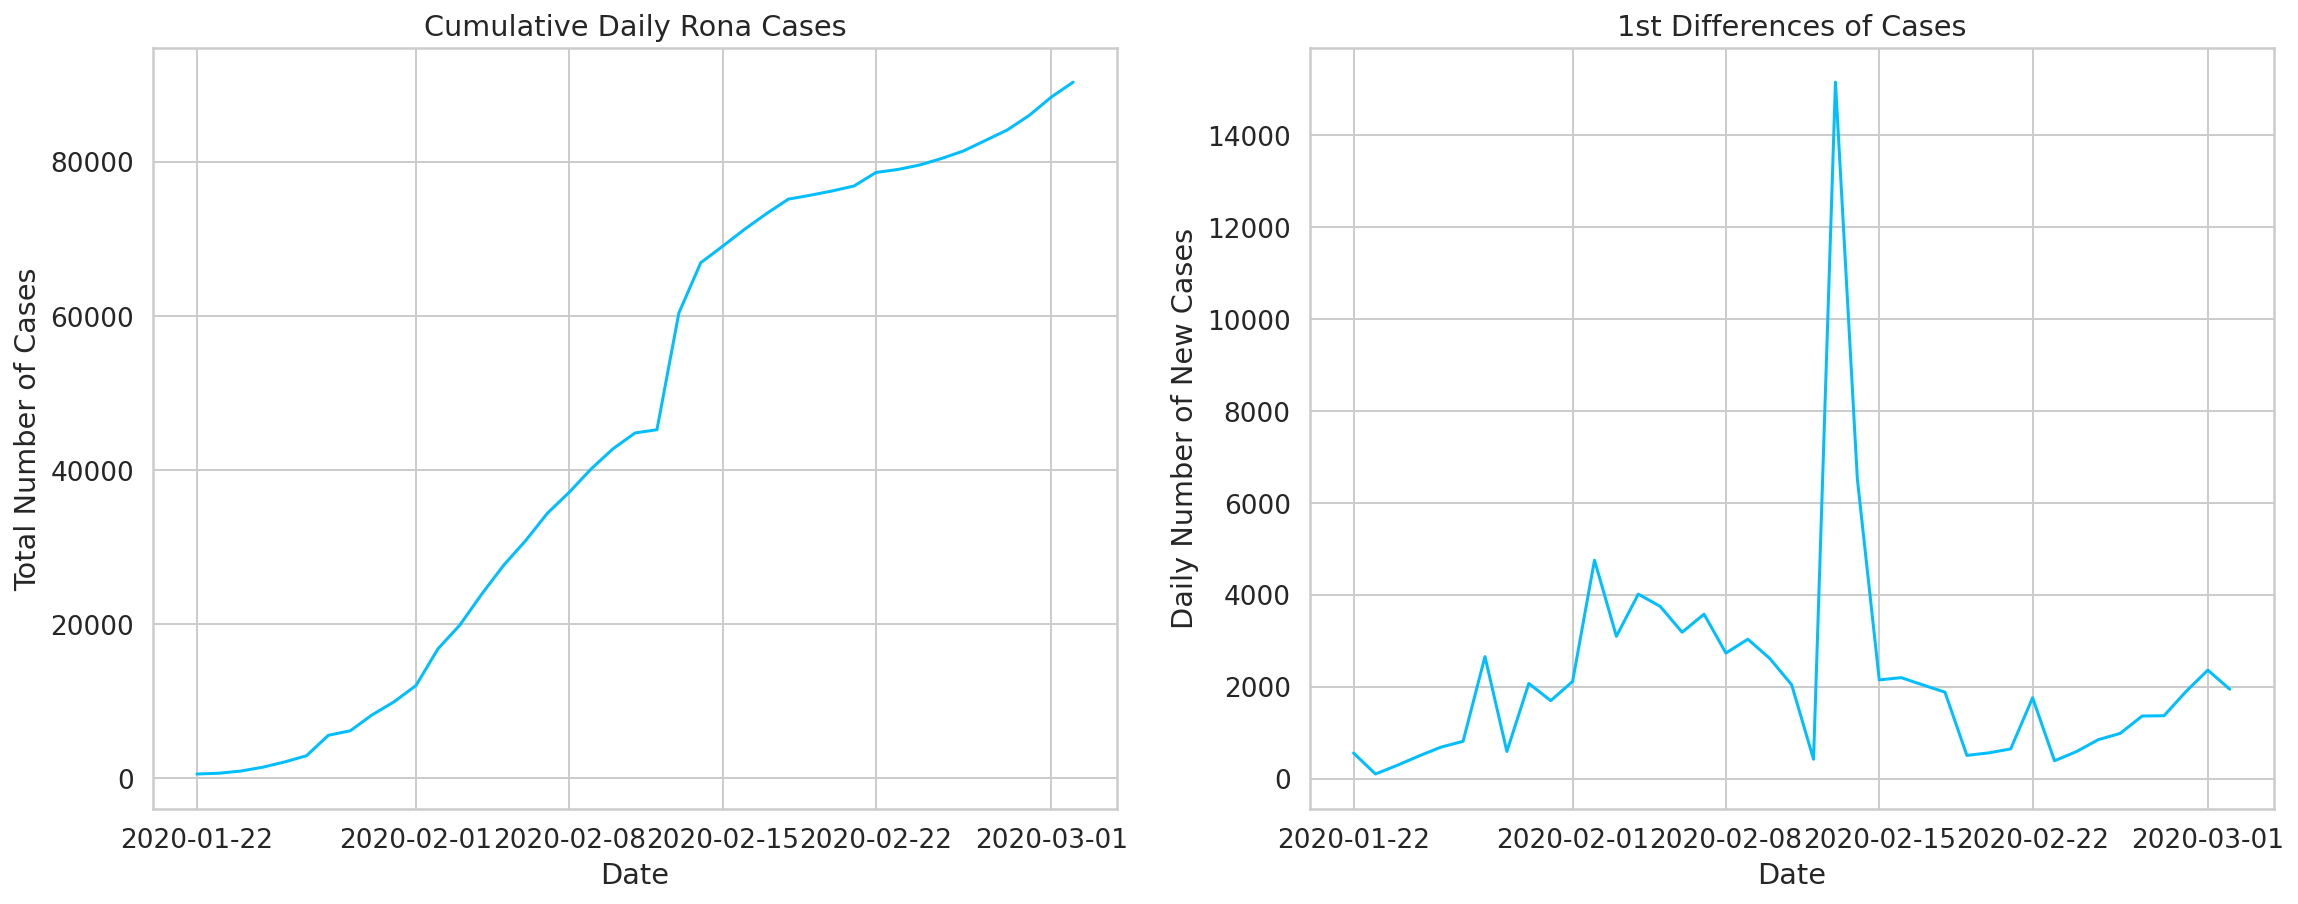

In [ ]:
plt.figure(figsize = (19, 7))
plt.subplot(121)
plt.plot(daily_cases)
plt.title("Cumulative Daily Rona Cases")
plt.ylabel("Total Number of Cases")
plt.xlabel("Date")

plt.subplot(122)
plt.plot(daily_cases_diff)
plt.title("1st Differences of Cases")
plt.ylabel("Daily Number of New Cases")
plt.xlabel("Date")

plt.show()

Note the enormous spike in the differences graph. This came from a recent change in testing criteria in China. The graph depics first differences in our data, where each $x'_t = x_t - x_{t - 1}$. This eliminates the cumulative cuild up we see in the first graph. 

Also note that this data does not reflect cases that are cleared as having recovered - it only depicts total number of positive tests and also does not account for a linear/non-linear trend. 

In [ ]:
daily_cases_diff2 = daily_cases_diff.diff().fillna(daily_cases_diff[0]).astype(np.int64)
daily_cases_diff2.head()

2020-01-22    555
2020-01-23   -457
2020-01-24    190
2020-01-25    205
2020-01-26    191
dtype: int64

[]

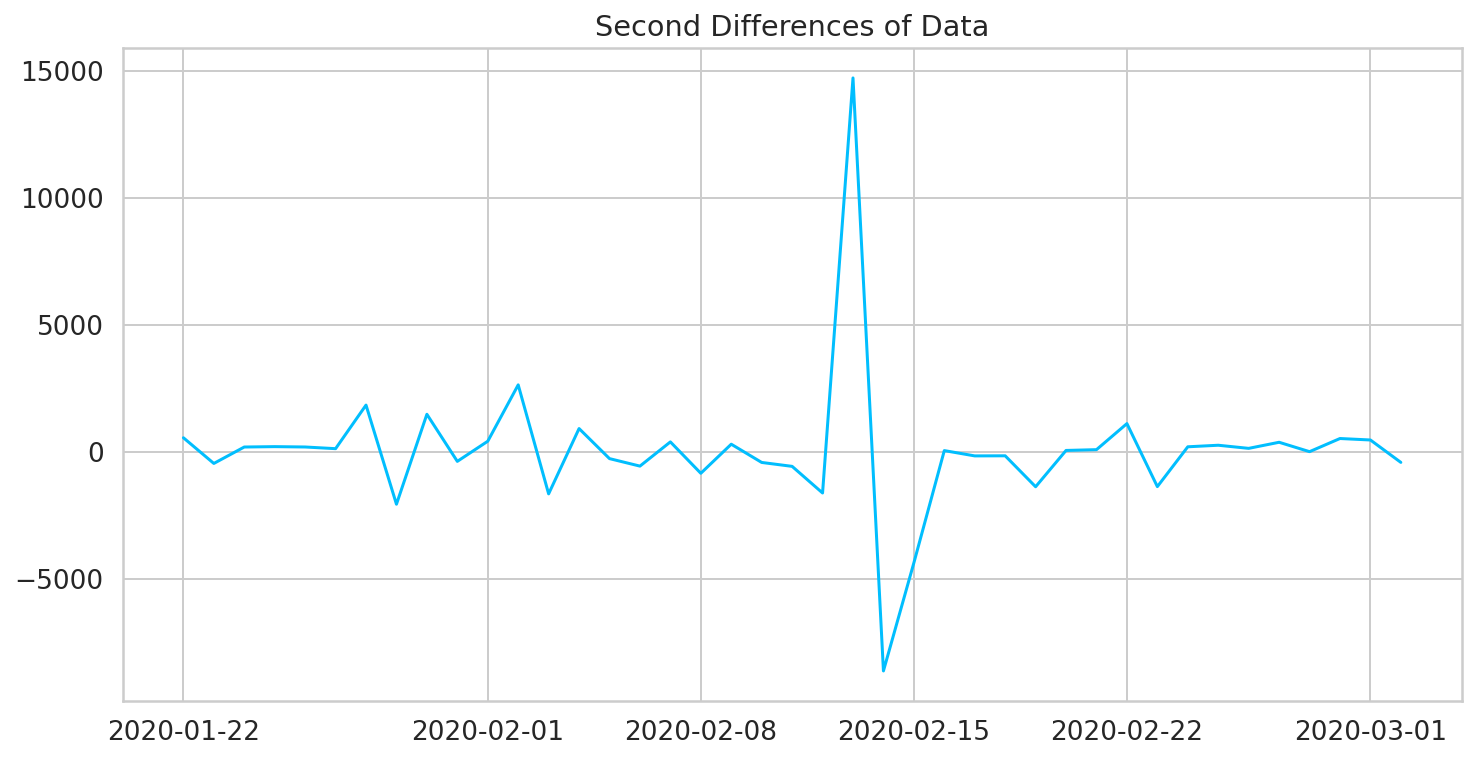

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(daily_cases_diff2)
plt.title("Second Differences of Data")
plt.plot()

In [ ]:
daily_cases_diff.shape

(41,)

In [ ]:
test_data_size = 14 # save 14 obs. for test data 

train_data = daily_cases_diff[:-test_data_size]
test_data = daily_cases_diff[-test_data_size:]

train_data.shape

(27,)

In [ ]:
# scale data for training 

scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis = 1))

train_data = scaler.transform(np.expand_dims(train_data, axis = 1))

test_data = scaler.transform(np.expand_dims(test_data, axis = 1))

In [ ]:
def create_sequences(data, sequence_length):
    """
    Takes large sequence of "data" 
    and makes smaller sequences for train, test splitting. 

    Data: ndarray
    sequence_length: length of output sequences 
    """
    xs = []
    ys = []

    length = len(data)

    for i in range(length - sequence_length - 1):

        x = data[i: i + sequence_length]
        y = data[i + sequence_length]

        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [ ]:
sequence_length = 5

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

X_train = torch.from_numpy(X_train).float() # cast to torch 
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
class predict(nn.Module): 
  """
  Stateless LSTM model class 
  """
  def __init__(self, in_features, number_hidden, squence_length, num_layers = 2): 
    super(predict, self).__init__()

    # save attributes all at once 
    self.__dict__.update(locals())

    # save lstm as attribute 
    self.lstm = nn.LSTM(input_size = self.in_features, 
                        hidden_size = self.number_hidden, 
                        num_layers = self.num_layers, 
                        dropout = 0.75) 
    
    # save linear layer as attribute 
    self.linear = nn.Linear(in_features = self.number_hidden, 
                            out_features = 1) 

  def reset_hidden_state(self):
    # resets hidden layers to zeros 
    # this LSTM is stateless 
    self.hidden = (torch.zeros(self.num_layers, self.squence_length, self.number_hidden), 
                   torch.zeros(self.num_layers, self.squence_length, self.number_hidden))
  
  def forward(self, sequences):

    # get output from LSTM
    output, self.hidden = self.lstm(sequences.view(len(sequences), self.squence_length, -1), self.hidden)

    # view / reshape 
    last_time_step = output.view(self.squence_length, len(sequences), self.number_hidden)[-1]

    # return final pred from linear layer 
    return self.linear(last_time_step)

In [ ]:
def train_model(model, train_data, train_labels, test_data = None, test_labels = None):

  # objective to minimize is MSE 
  objective = torch.nn.MSELoss()

  # use Adam optimizer to do so 
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)

  train_losses = []
  test_losses = [] 

  loop = tqdm(total = len(train_data), position = 0) 

  for epoch in range(100):

    # reset gradients 
    optimizer.zero_grad()

    # set hidden layers to zeros 
    model.reset_hidden_state()

    # predict y_hats from model 
    y_pred = model(X_train)

    # calculate MSE loss  
    train_loss = objective(y_pred.float(), y_train) 

    # update to list of losses 
    train_losses.append((epoch, train_loss.item())) 
    train_loss.backward(retain_graph = True)

    y_test_pred = model(X_test)
    test_loss = objective(y_test_pred.float(), y_test)

    test_losses.append(test_loss.item())
    test_loss.backward()

    if epoch % 25 == 0: 
      loop.set_description("Epoch {}  Train Loss: {:.4f}  Test Loss:  {:.4f}\n".format(epoch, train_loss.item(), test_loss.item()))

    optimizer.step()

  loop.close()

  return model.eval(), train_losses, test_losses 

In [ ]:
model = predict(in_features = 1, number_hidden = 512, squence_length = 5, num_layers = 2)

model, train_losses, test_losses = train_model(model, X_train, y_train, X_test, y_test)  

Epoch 0  Train Loss: 0.0776  Test Loss:  0.0052
Epoch 25  Train Loss: 0.0660  Test Loss:  0.0023
Epoch 50  Train Loss: 0.0559  Test Loss:  0.0016
Epoch 75  Train Loss: 0.0502  Test Loss:  0.0029
Epoch 75  Train Loss: 0.0502  Test Loss:  0.0029
:   0%|          | 0/21 [00:39<?, ?it/s]


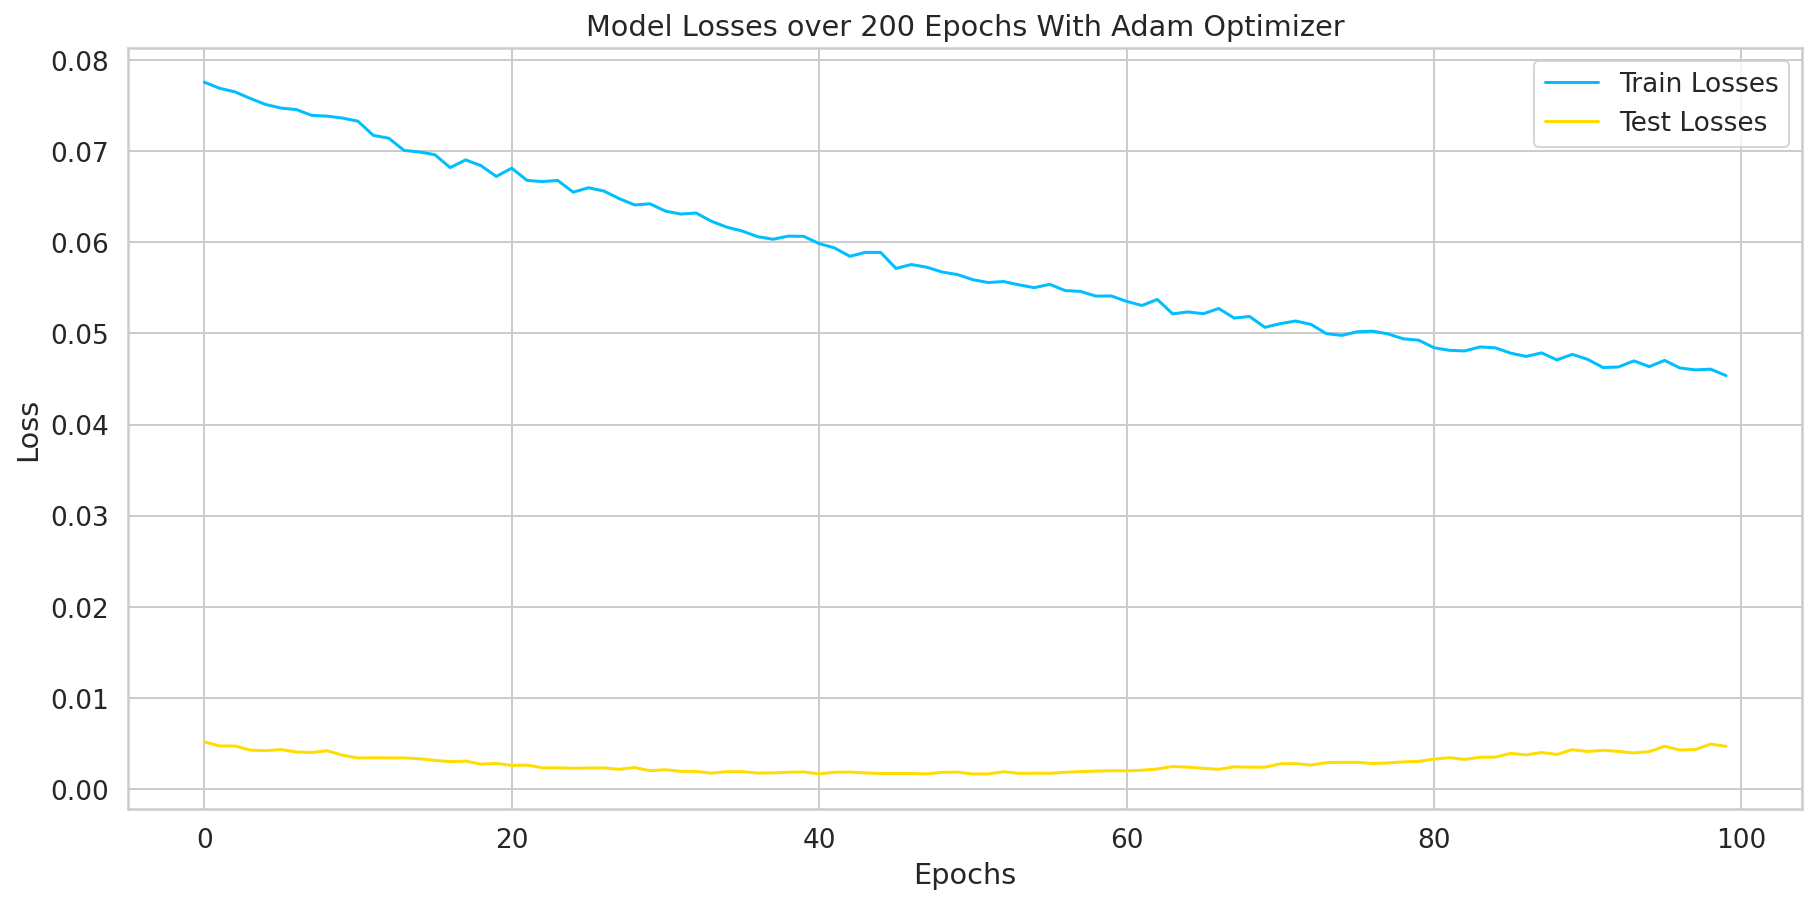

In [ ]:
t, train_loss_vals = zip(*train_losses)

plt.figure(figsize = (15, 7))
plt.plot(t, train_loss_vals, label = "Train Losses")
plt.plot(t, test_losses, label = "Test Losses")

plt.title("Model Losses over 200 Epochs With Adam Optimizer")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

This is interesting: our test loss is lower accross all epochs than our train loss. Why is this? 

One reason could be our regularization methods. 

In [ ]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, sequence_length, 1).float()

In [ ]:
true_cases = scaler.inverse_transform(np.expand_dims(y_test.flatten().numpy(), axis = 0)).flatten()

predicted_cases = scaler.inverse_transform(np.expand_dims(preds, axis = 0)).flatten() 

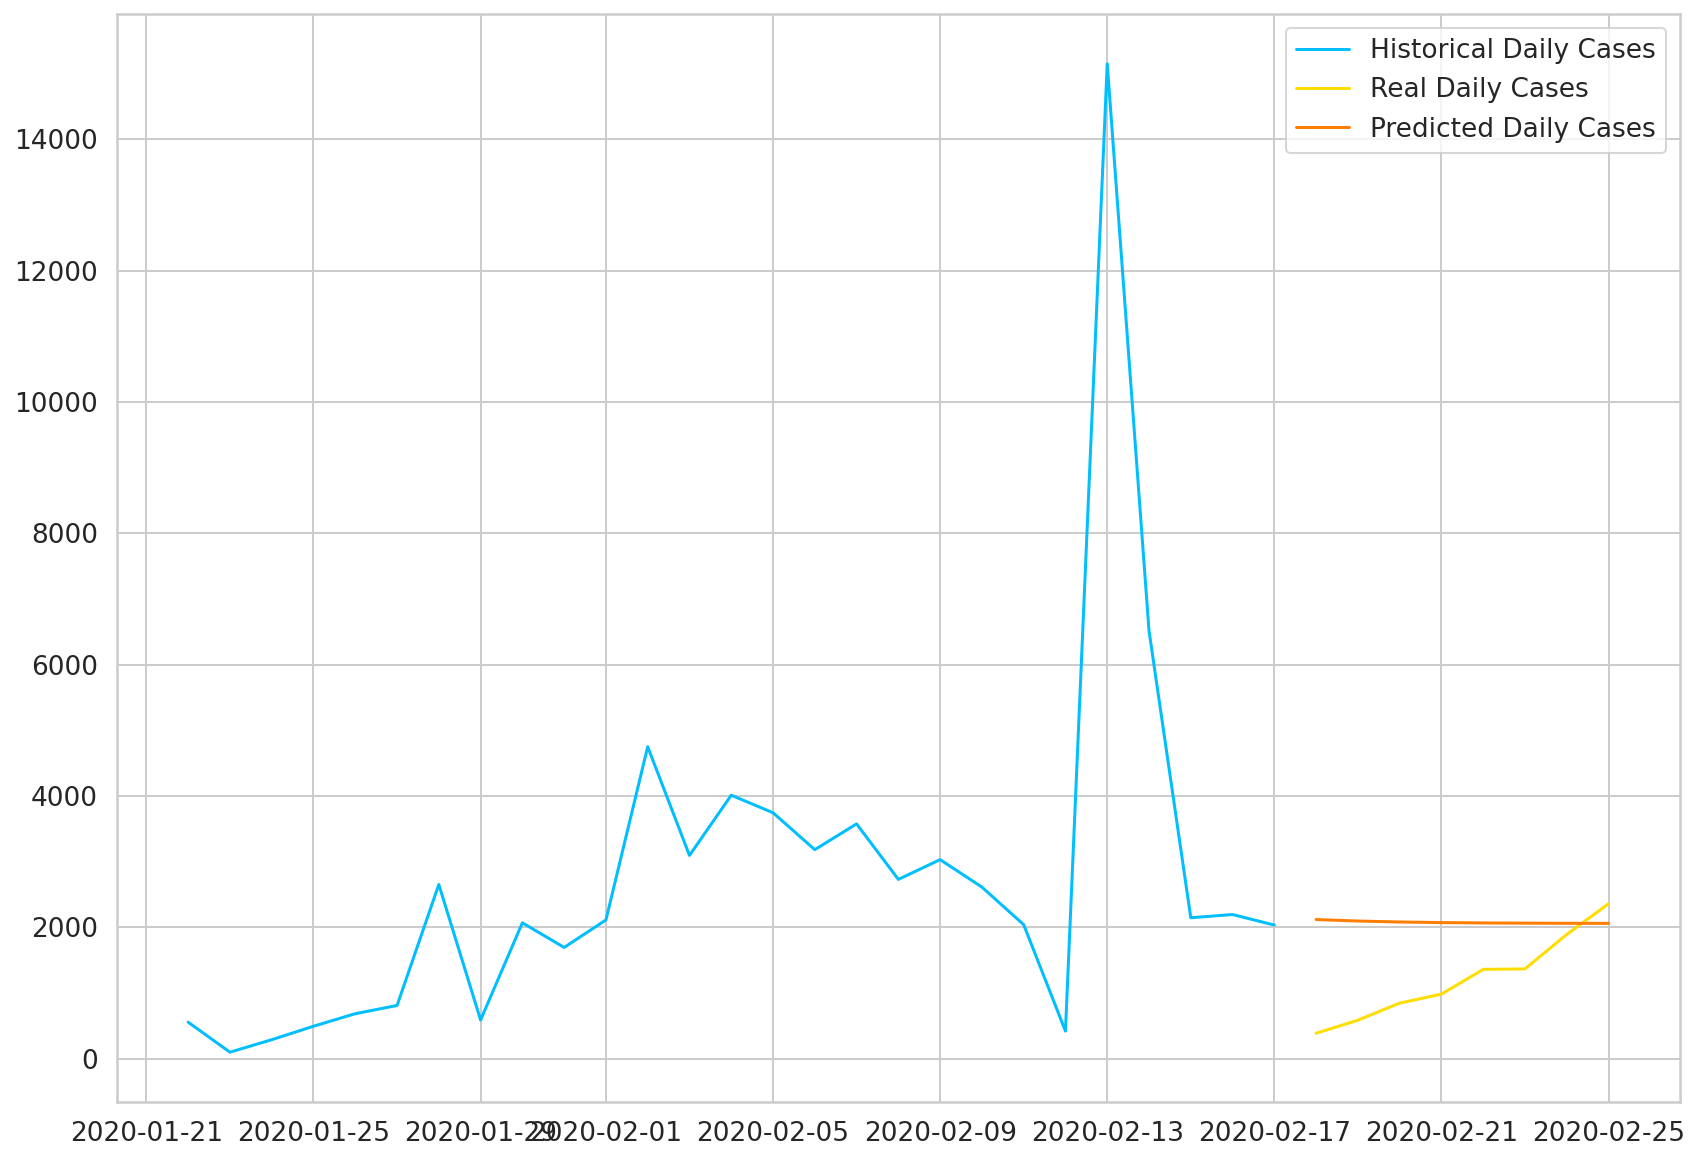

In [ ]:
plt.plot(daily_cases.index[:len(train_data)], scaler.inverse_transform(train_data).flatten(), label='Historical Daily Cases')

plt.plot(daily_cases.index[len(train_data):len(train_data) + len(true_cases)], true_cases, label='Real Daily Cases') 

plt.plot(daily_cases.index[len(train_data):len(train_data) + len(true_cases)], predicted_cases, label='Predicted Daily Cases')

plt.legend()
plt.show() 

In [ ]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases_diff, axis = 1))

all_data = scaler.transform(np.expand_dims(daily_cases_diff, axis = 1))

all_data.shape

(41, 1)

In [ ]:
X, y = create_sequences(all_data, sequence_length)

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

model = predict(in_features = 1, number_hidden = 512, squence_length = 5, num_layers = 2)

model, train_losses, _ = train_model(model, X, y)

Epoch 0 Train Loss: 0.0863 Test Loss:  0.0076
Epoch 0 Train Loss: 0.0863 Test Loss:  0.0076
Epoch 25 Train Loss: 0.0451 Test Loss:  0.0049
Epoch 25 Train Loss: 0.0451 Test Loss:  0.0049
Epoch 50 Train Loss: 0.0452 Test Loss:  0.0035
Epoch 50 Train Loss: 0.0452 Test Loss:  0.0035
Epoch 75 Train Loss: 0.0420 Test Loss:  0.0023
Epoch 75 Train Loss: 0.0420 Test Loss:  0.0023
Epoch 100 Train Loss: 0.0452 Test Loss:  0.0042
Epoch 100 Train Loss: 0.0452 Test Loss:  0.0042
Epoch 125 Train Loss: 0.0434 Test Loss:  0.0058
Epoch 125 Train Loss: 0.0434 Test Loss:  0.0058
Epoch 150 Train Loss: 0.0377 Test Loss:  0.0028
Epoch 150 Train Loss: 0.0377 Test Loss:  0.0028
Epoch 175 Train Loss: 0.0409 Test Loss:  0.0033
Epoch 175 Train Loss: 0.0409 Test Loss:  0.0033
Epoch 175 Train Loss: 0.0409 Test Loss:  0.0033
:  23%|██▎       | 8/35 [01:06<03:45,  8.35s/it]


In [ ]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
  test_seq = X[:1]
  preds = []
  for _ in range(DAYS_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, sequence_length, 1).float()

In [ ]:
predicted_cases = scaler.inverse_transform(np.expand_dims(preds, axis = 0)).flatten()

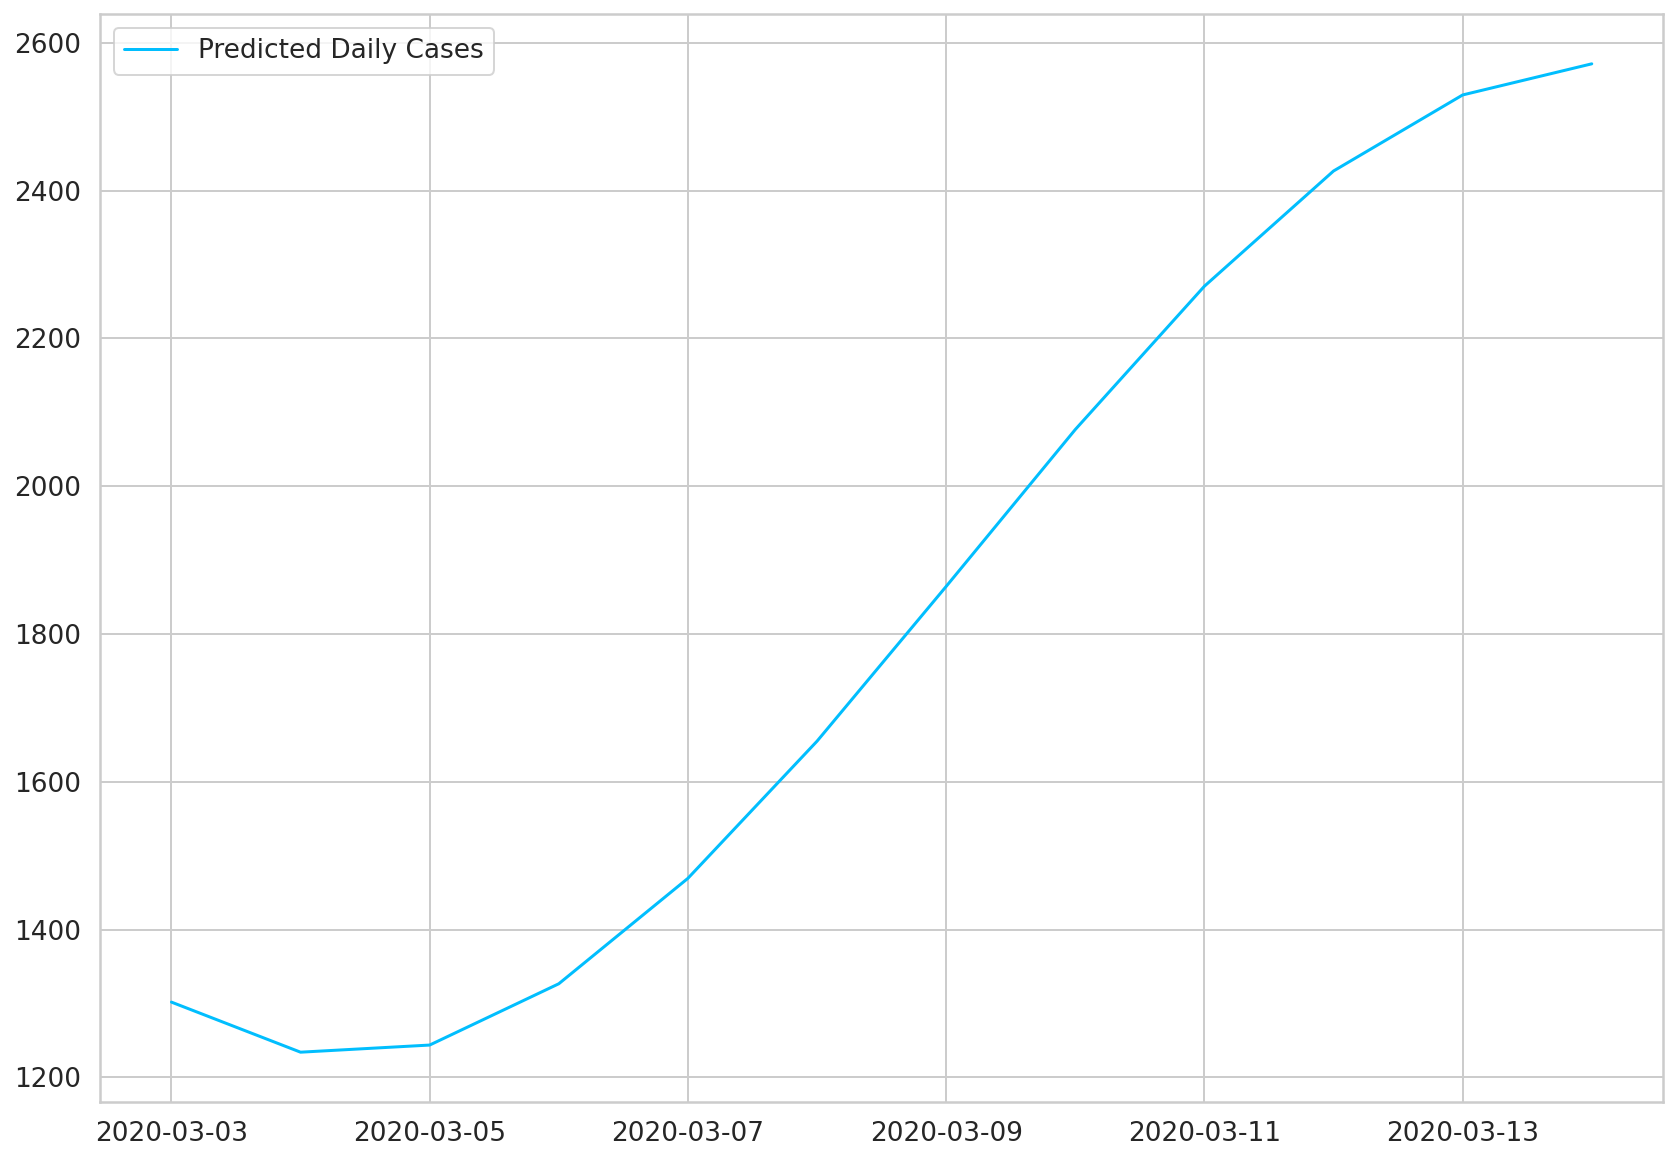

In [ ]:
predicted_index = pd.date_range(
  start=daily_cases.index[-1],
  periods=DAYS_TO_PREDICT + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()
plt.show()

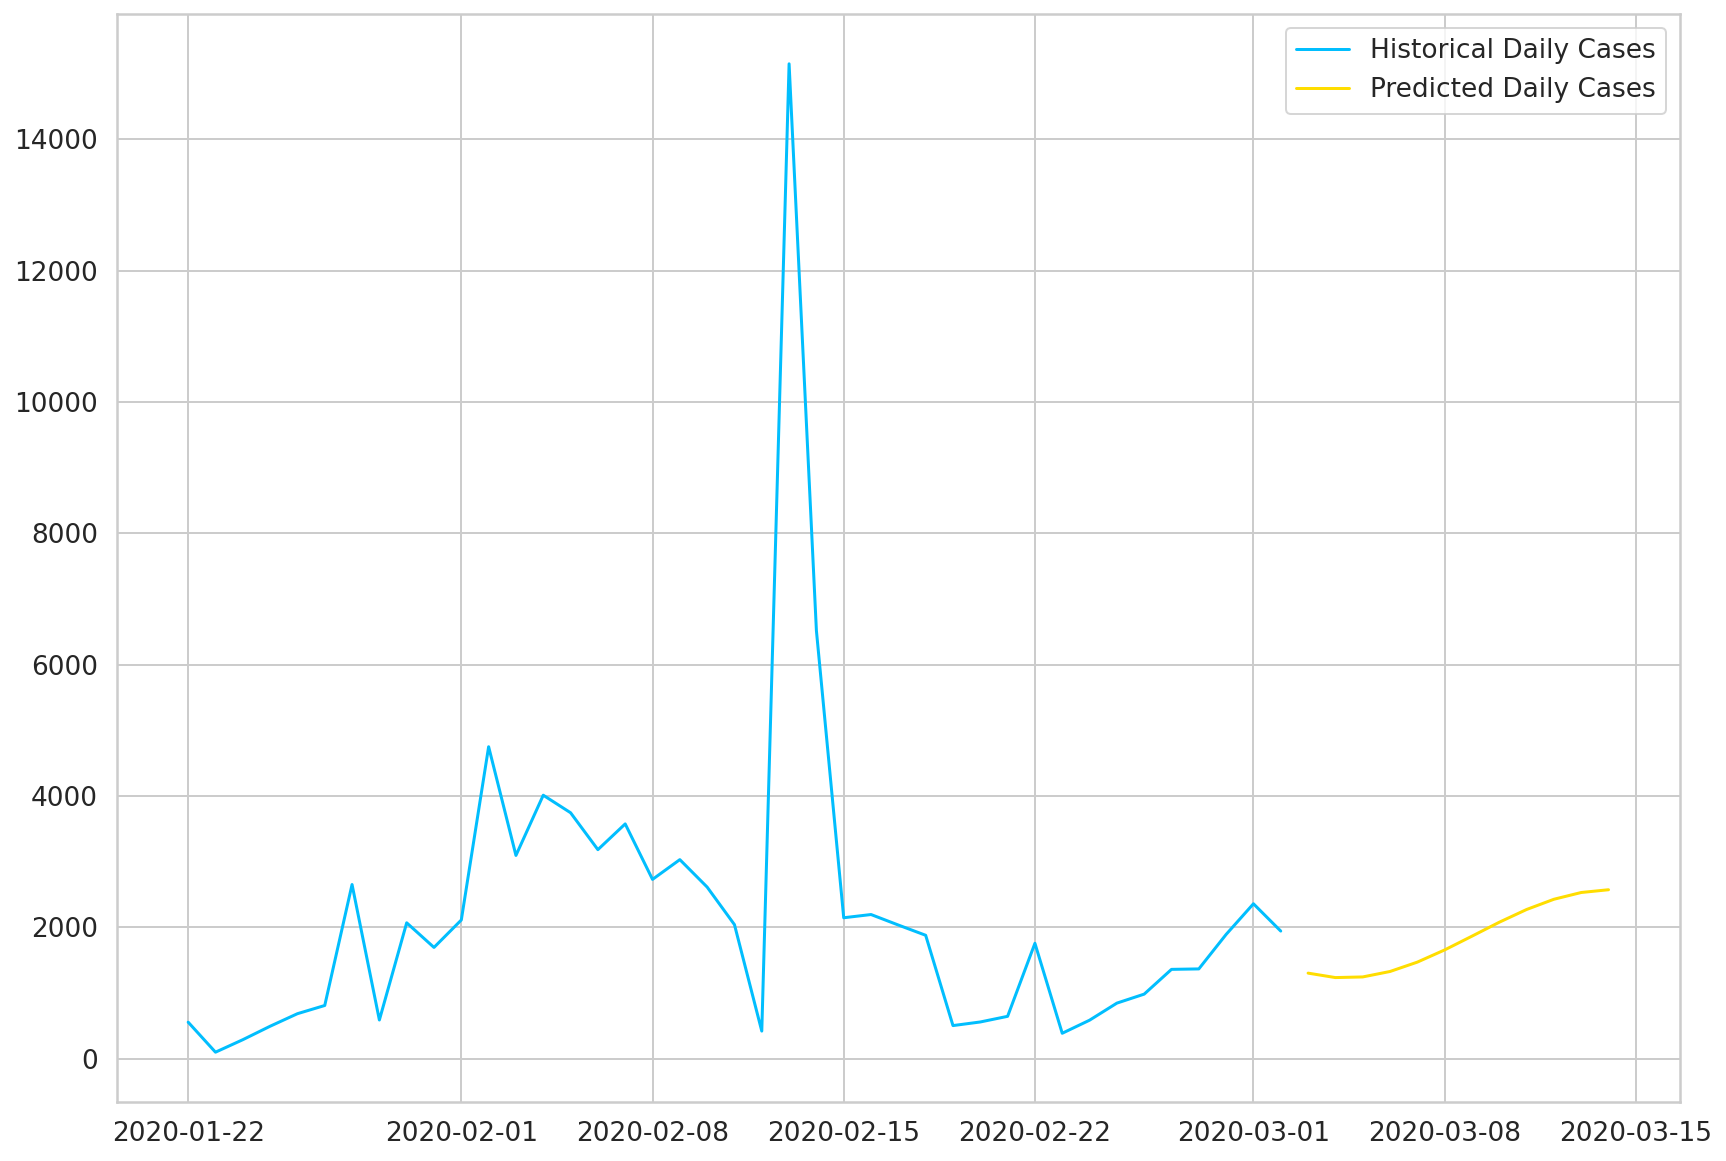

In [ ]:
plt.plot(daily_cases_diff, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()
plt.show()